In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from collections import defaultdict
import random

In [2]:
# Load dataset
data = pd.read_csv('data/iris.csv')

# Separate features and target
X = data.drop(columns=['species'])
y = data['species'].copy()

In [3]:
# Encode target labels (if not already integers)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into clean training and validation sets (80% train, 20% val)
X_train_clean, X_val, y_train_clean, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [4]:
# Define poisoning percentages
poisoning_levels = [0, 10, 20, 30, 40, 50]  # in percent
num_trials = 5  # repeat experiments to get average

val_results = defaultdict(list)
train_results = defaultdict(list)

In [5]:
def poison_labels(y, percent, n_classes, seed=None):
    y_poisoned = y.copy()
    n_poison = int(len(y) * percent / 100)
    np.random.seed(seed)
    indices = np.random.choice(len(y), n_poison, replace=False)
    
    for idx in indices:
        original_label = y_poisoned[idx]
        new_label = np.random.choice([l for l in range(n_classes) if l != original_label])
        y_poisoned[idx] = new_label
    
    return y_poisoned

In [6]:
# Run trials
for poison_percent in poisoning_levels:
    for trial in range(num_trials):
        # Poison training labels
        y_train_poisoned = poison_labels(y_train_clean, poison_percent, n_classes=len(np.unique(y_encoded)), seed=trial)

        # Train classifier
        clf = DecisionTreeClassifier(random_state=trial)
        clf.fit(X_train_clean, y_train_poisoned)

        # Evaluate
        y_val_pred = clf.predict(X_val)
        y_train_pred = clf.predict(X_train_clean)

        val_acc = accuracy_score(y_val, y_val_pred)
        train_acc = accuracy_score(y_train_clean, y_train_pred)  # Note: comparing to clean labels

        val_results[poison_percent].append(val_acc)
        train_results[poison_percent].append(train_acc)

In [7]:
# Compute stats
mean_val_acc = [np.mean(val_results[p]) for p in poisoning_levels]
std_val_acc = [np.std(val_results[p]) for p in poisoning_levels]

mean_train_acc = [np.mean(train_results[p]) for p in poisoning_levels]
std_train_acc = [np.std(train_results[p]) for p in poisoning_levels]

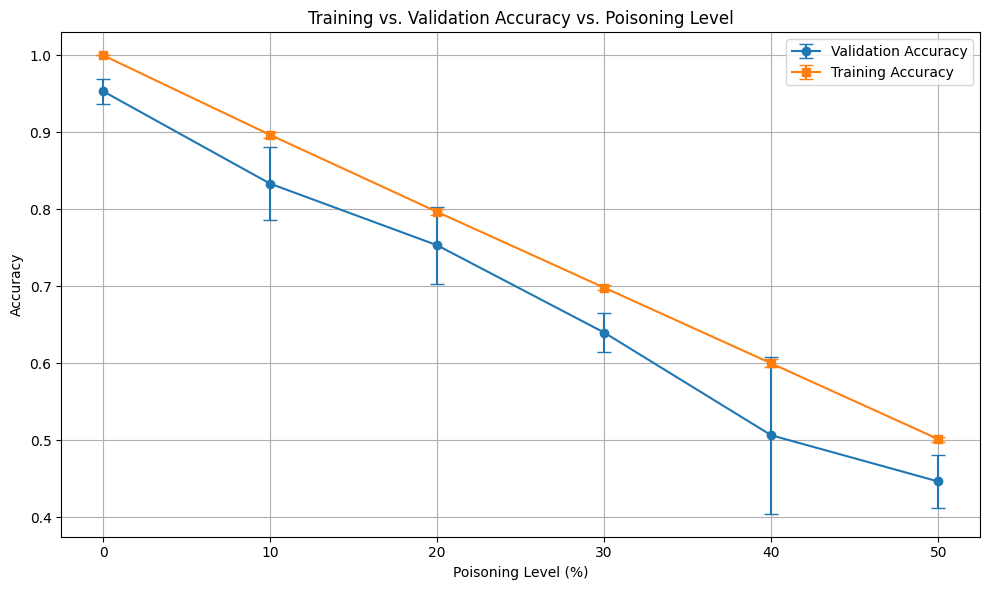

In [8]:
# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(poisoning_levels, mean_val_acc, yerr=std_val_acc, fmt='-o', capsize=5, label='Validation Accuracy')
plt.errorbar(poisoning_levels, mean_train_acc, yerr=std_train_acc, fmt='-s', capsize=5, label='Training Accuracy')
plt.title("Training vs. Validation Accuracy vs. Poisoning Level")
plt.xlabel("Poisoning Level (%)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()